# **07. 지리 정보 시각화**  

In [17]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import pyproj

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns
import ast
import warnings
warnings.filterwarnings("ignore")

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

#### **대한민국 행정구역 데이터: http://www.gisdeveloper.co.kr/?p=2332**

In [18]:
# 시군구 데이터
korea_small_file = "C:/Users/henna/VSCODE/teamproject_apartment/sig.shp"
korea_small = gpd.read_file(korea_small_file, encoding='euc-kr')
korea_small.tail(2)

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
248,51820,Goseong-gun,고성군,"MULTIPOLYGON (((1091705.056 2034023.203, 10917..."
249,51830,Yangyang-gun,양양군,"MULTIPOLYGON (((1102146.292 2010704.587, 11021..."


In [19]:
# 시도데이터
korea_big_file = "C:/Users/henna/VSCODE/teamproject_apartment/ctprvn.shp"
korea_big = gpd.read_file(korea_big_file, encoding='euc-kr')
korea_big.head(2)

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,11,Seoul,서울특별시,"POLYGON ((966987.226 1941110.946, 966987.119 1..."
1,26,Busan,부산광역시,"MULTIPOLYGON (((1148194.981 1685460.055, 11481..."


In [20]:
korea_small['시도'] = korea_small['SIG_CD'].apply(lambda x: x[0:2])
korea = pd.merge(korea_small, korea_big, left_on='시도', right_on='CTPRVN_CD', how='left')

In [21]:
korea[korea['SIG_KOR_NM']=='중구']

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry_x,시도,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry_y
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1...",11,11,Seoul,서울특별시,"POLYGON ((966987.226 1941110.946, 966987.119 1..."
25,26110,Jung-gu,중구,"POLYGON ((1139632.900 1681213.674, 1139636.835...",26,26,Busan,부산광역시,"MULTIPOLYGON (((1148194.981 1685460.055, 11481..."
41,27110,Jung-gu,중구,"POLYGON ((1099266.034 1764845.475, 1099328.023...",27,27,Daegu,대구광역시,"POLYGON ((1087859.999 1760097.461, 1087859.951..."
50,28110,Jung-gu,중구,"MULTIPOLYGON (((912369.264 1929393.401, 912478...",28,28,Incheon,인천광역시,"MULTIPOLYGON (((847834.755 1881816.658, 847840..."
66,30140,Jung-gu,중구,"POLYGON ((995945.175 1811588.887, 995945.178 1...",30,30,Daejeon,대전광역시,"POLYGON ((990946.725 1832389.260, 991057.692 1..."
70,31110,Jung-gu,중구,"POLYGON ((1165946.465 1735060.511, 1165927.884...",31,31,Ulsan,울산광역시,"MULTIPOLYGON (((1167949.952 1710285.043, 11679..."


In [22]:
korea.drop(['SIG_ENG_NM', 'CTPRVN_CD', 'CTP_ENG_NM', 'geometry_y'], axis=1, inplace=True)
korea.rename(columns={'geometry_x': 'geometry'}, inplace=True)

In [23]:
our_data = korea[korea['CTP_KOR_NM'].isin(['서울특별시', '인천광역시', '경기도'])]
our_data.tail()

,SIG_CD,SIG_KOR_NM,geometry,시도,CTP_KOR_NM
113,41650,포천시,"POLYGON ((966892.447 1974877.390, 966891.483 1...",41,경기도
114,41670,여주시,"POLYGON ((1001702.361 1937472.187, 1001797.089...",41,경기도
115,41800,연천군,"MULTIPOLYGON (((969139.245 2026871.151, 969278...",41,경기도
116,41820,가평군,"POLYGON ((995776.586 2003840.576, 995850.072 2...",41,경기도
117,41830,양평군,"POLYGON ((982850.492 1946970.632, 982851.709 1...",41,경기도


#### **서울·경기·인천** 

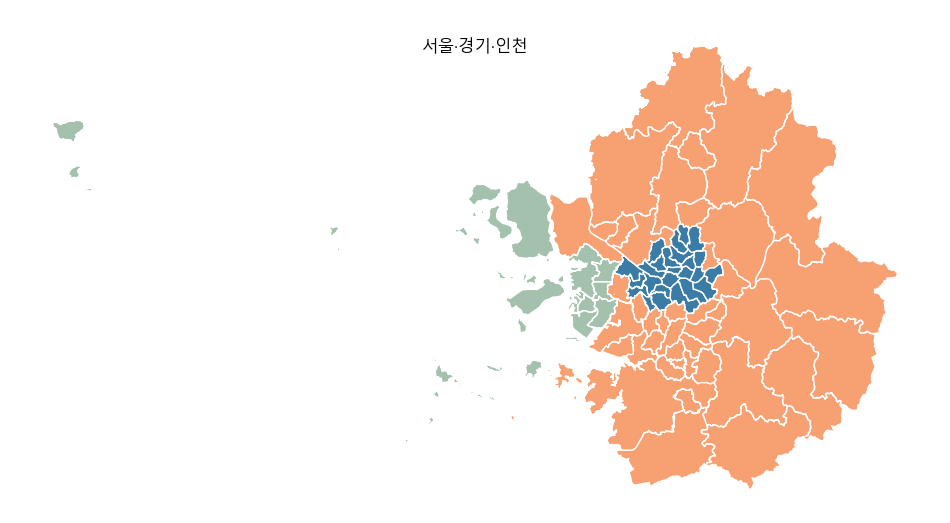

In [24]:
plt.figure(figsize=(12, 9))

seoul = our_data[our_data['CTP_KOR_NM'] == '서울특별시'] 
gyeonggi = our_data[our_data['CTP_KOR_NM'] == '경기도'] 
incheon = our_data[our_data['CTP_KOR_NM'] == '인천광역시'] 

our_data.plot(color='lightgray', edgecolor='w', ax=plt.gca())
seoul.plot(color='#3A7CA5', edgecolor='w', label='Seoul', ax=plt.gca())
gyeonggi.plot(color='#F7A072', edgecolor='w', label='Gyeonggi', ax=plt.gca())
incheon.plot(color='#A3C1AD', edgecolor='w', label='Incheon', ax=plt.gca())

plt.title("서울·경기·인천", y=0.9)
plt.axis('off')

plt.show()


#### **분석 대상 데이터에 존재하는 아파트 표시**

In [25]:
apartment = pd.read_csv("apartment_20230910.csv")
apartment = apartment.copy()
apartment = apartment[['아파트명', '법정동주소', '위도', '경도']]
apartment = apartment.drop_duplicates()

In [26]:
source_crs = pyproj.CRS("EPSG:4326")
target_crs = pyproj.CRS("EPSG:5179")

transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

apartment_transformed = apartment.copy()

x, y = transformer.transform(apartment['경도'], apartment['위도'])
apartment_transformed['경도'] = x
apartment_transformed['위도'] = y
apartment_transformed['geometry'] = gpd.points_from_xy(apartment_transformed['경도'], apartment_transformed['위도'])
apartment_transformed_gdf = gpd.GeoDataFrame(apartment_transformed, 
                                              geometry=gpd.points_from_xy(apartment_transformed['경도'], apartment_transformed['위도']))

apartment_transformed_gdf.head()


,아파트명,법정동주소,위도,경도,geometry
0,올림픽파크포레온,서울특별시 강동구 둔촌1동 170-1,1.947126e+06,968236.860961,POINT (968236.861 1947126.036)
16,디에이치퍼스티어아이파크,서울특별시 강남구 개포1동 660-4번지 일원,1.942485e+06,960872.752796,POINT (960872.753 1942484.782)
27,산성역자이푸르지오(성남),경기도 성남시 수정구 신흥동 1132,1.938886e+06,968853.666618,POINT (968853.667 1938885.875)
37,매교역푸르지오SKVIEW(수원),경기도 수원시 팔달구 매교동 209-14번지 일원,1.918821e+06,957416.681153,POINT (957416.681 1918820.550)
45,수원센트럴아이파크자이,경기도 수원시 팔달구 인계동 847-3,1.919295e+06,957675.412078,POINT (957675.412 1919295.305)


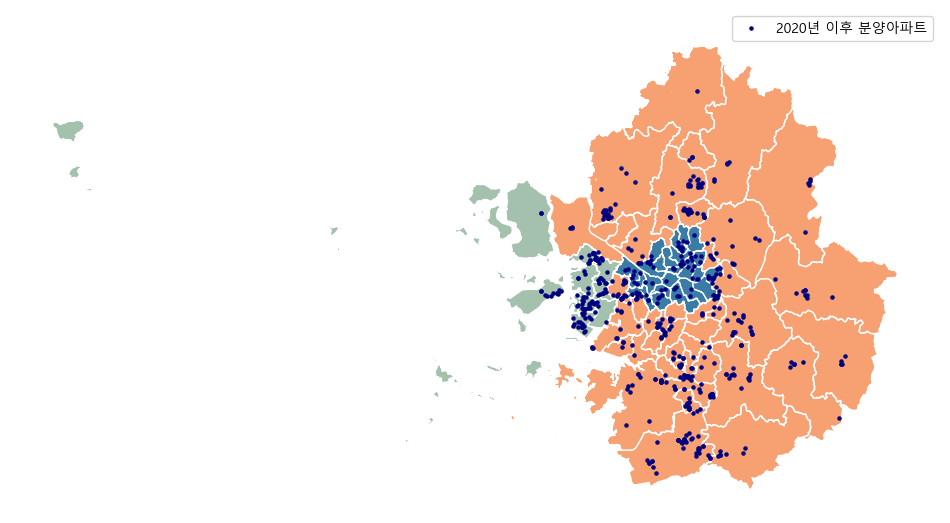

In [27]:
fig, ax = plt.subplots(figsize=(12, 9))

our_data.plot(color='lightgray', edgecolor='w', ax=ax)
seoul = our_data[our_data['CTP_KOR_NM'] == '서울특별시'] 
gyeonggi = our_data[our_data['CTP_KOR_NM'] == '경기도'] 
incheon = our_data[our_data['CTP_KOR_NM'] == '인천광역시'] 

seoul.plot(color='#3A7CA5', edgecolor='w', label='Seoul', ax=ax)
gyeonggi.plot(color='#F7A072', edgecolor='w', label='Gyeonggi', ax=ax)
incheon.plot(color='#A3C1AD', edgecolor='w', label='Incheon', ax=ax)

apartment_transformed_gdf.plot(ax=ax, marker='o', color='navy', markersize=5, label='2020년 이후 분양아파트')

fig.patch.set_facecolor('none')
# plt.title("서울·경기·인천", y=0.9)
plt.axis('off')
plt.legend()
plt.show()


화성, 평택, 성남, 과천, 하남, 광명, 수원

In [28]:
our_data[our_data['CTP_KOR_NM'] == '경기도']['SIG_KOR_NM'].unique()

array(['수원시 장안구', '수원시 권선구', '수원시 팔달구', '수원시 영통구', '성남시 수정구', '성남시 중원구',
       '성남시 분당구', '의정부시', '안양시 만안구', '안양시 동안구', '부천시', '광명시', '평택시',
       '동두천시', '안산시 상록구', '안산시 단원구', '고양시 덕양구', '고양시 일산동구', '고양시 일산서구',
       '과천시', '구리시', '남양주시', '오산시', '시흥시', '군포시', '의왕시', '하남시', '용인시 처인구',
       '용인시 기흥구', '용인시 수지구', '파주시', '이천시', '안성시', '김포시', '화성시', '광주시',
       '양주시', '포천시', '여주시', '연천군', '가평군', '양평군'], dtype=object)

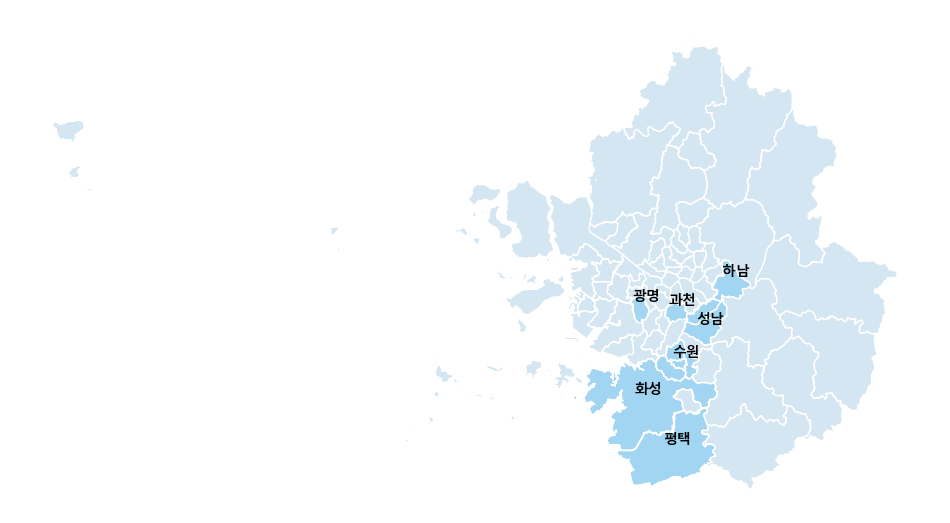

In [29]:
fig, ax = plt.subplots(figsize=(12, 9))

our_data.plot(color='lightgray', edgecolor='w', ax=ax)

regions = ['서울특별시', '경기도', '인천광역시']
for region in regions:
    region_data = our_data[our_data['CTP_KOR_NM'] == region] 
    region_data.plot(color='#D4E6F1', edgecolor='w', ax=ax)

cities = ['화성시', '평택시', '성남시 수정구', '성남시 중원구', '성남시 분당구', '과천시', '하남시', '광명시', '수원시 장안구', '수원시 권선구', '수원시 팔달구', '수원시 영통구']
for city in cities:
    city_data = our_data[our_data['SIG_KOR_NM'] == city]
    city_data.plot(color='#A2D5F2', edgecolor='w', label='seongnam', ax=ax)

our_city = our_data[our_data['SIG_KOR_NM'].isin(['화성시', '평택시', '과천시', '하남시', '광명시',
                                                 '성남시 분당구', '수원시 팔달구'])]
our_city.loc[our_city['SIG_KOR_NM'].str.contains('성남시'), 'SIG_KOR_NM'] = '성남시'
our_city.loc[our_city['SIG_KOR_NM'].str.contains('수원시'), 'SIG_KOR_NM'] = '수원시'

for idx, row in our_city.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax.annotate(row['SIG_KOR_NM'][0:2], xy=(x, y), xytext=(-5, 5), textcoords='offset points', fontsize=10, color='black', fontweight='bold')
    
fig.patch.set_facecolor('none')
# plt.title("화성·평택·성남·과천·하남·광명·수원", y=0.9)
plt.axis('off')
plt.show()

**2023년 변경 후 투기과열지구 및 분양가상한제 적용 지역**
* 서울시: 서초구, 강남구, 송파구, 용산구


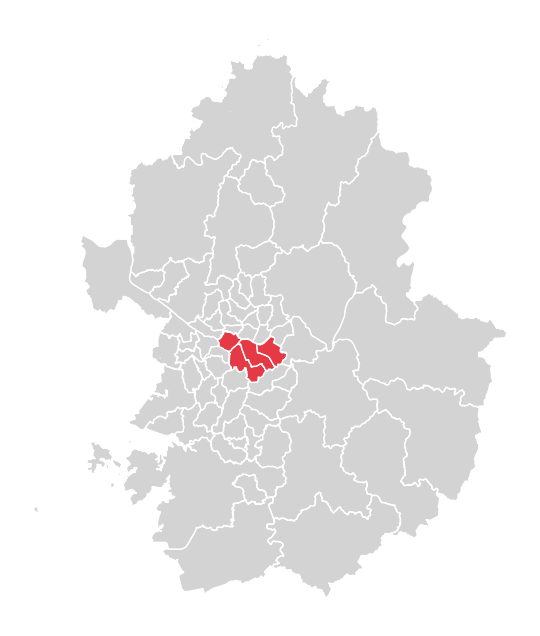

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

for region in ['서울특별시', '경기도']:
    data = our_data[our_data['CTP_KOR_NM'] == region]
    data.plot(color='lightgray', edgecolor='w', ax=ax)
    
after_2023 = ['서초구', '강남구', '용산구', '송파구']

for city in after_2023:
    data = our_data[our_data['SIG_KOR_NM'] == city]
    data.plot(color='#E63946', edgecolor='w', ax=ax)

fig.patch.set_facecolor('none')

# our_city = our_data[our_data['SIG_KOR_NM'].isin(after_2023)]
# for idx, row in our_city.iterrows():
#     x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
#     ax.annotate(row['SIG_KOR_NM'], xy=(x, y), xytext=(-15, -15), textcoords='offset points', fontsize=10, color='black', fontweight='bold')
    
plt.axis('off')
plt.show()

In [31]:
korea_smaller_file = "C:/Users/henna/VSCODE/teamproject_apartment/emd.shp"
korea_smaller = gpd.read_file(korea_smaller_file, encoding='euc-kr')
korea_smaller.tail(2)

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
5063,51830340,Hyeonnam-myeon,현남면,"MULTIPOLYGON (((1114466.017 1992227.421, 11145..."
5064,51830350,Ganghyeon-myeon,강현면,"MULTIPOLYGON (((1099133.051 2014106.791, 10991..."


In [32]:
korea_smaller['smthng'] = korea_smaller['EMD_CD'].apply(lambda x: x[0:5])

if set(korea['SIG_CD'].unique()) == set(korea_smaller['smthng'].unique()):
    print("두 집합은 일치합니다.")
else:
    print("두 집합은 일치하지 않습니다.")

두 집합은 일치합니다.


In [33]:
smaller_df = pd.merge(korea_smaller, korea, left_on = 'smthng', right_on='SIG_CD', how='left')
smaller_df.drop(['EMD_CD', 'EMD_ENG_NM', 'smthng', 'SIG_CD', 'geometry_y', '시도'], axis=1, inplace=True)
smaller_df.rename(columns={'geometry_x': 'geometry'}, inplace=True)

확인

In [34]:
smaller_df[smaller_df['SIG_KOR_NM'] == '용산구']['EMD_KOR_NM'].unique()

array(['후암동', '용산동2가', '용산동4가', '갈월동', '남영동', '용산동1가', '동자동', '서계동',
       '청파동1가', '청파동2가', '청파동3가', '원효로1가', '원효로2가', '신창동', '산천동', '청암동',
       '원효로3가', '원효로4가', '효창동', '도원동', '용문동', '문배동', '신계동', '한강로1가',
       '한강로2가', '용산동3가', '용산동5가', '한강로3가', '이촌동', '이태원동', '한남동', '동빙고동',
       '서빙고동', '주성동', '용산동6가', '보광동'], dtype=object)

**2023년 1월 3일 변경 전 분양가상한제 적용지역**
* 서울특별시: 강남구, 서초구, 송파구, 강동구, 영등포구, 마포구, 성동구, 동작구, 양천구, 용산구, 중구, 광진구, 서대문구  
    * 강서구(5개동)  : 방화동, 공항동, 마곡동, 등촌동, 화곡동   
    * 노원구(4개동)  : 상계동, 중계동, 하계동, 월계동  
    * 동대문구(8개동) : 제기동, 회기동, 이문동, 휘경동, 청량리동, 답십리동, 전농동, 용두동 
    * 성북구(13개동) : 정릉동, 성북동, 동소문동(2/3가), 삼선동(1/2/3가), 보문동(1가), 안암동(3가), 동선동(4가), 돈암동, 길음동, 장위동    
    * 은평구(7개동) : 갈현동, 불광동, 대조동, 역촌동, 신사동, 증산동, 수색동   
* 경기도
    * 과천시(5개동) : 별양동, 부림동, 원문동, 주암동, 중앙동  
    * 하남시(4개동) : 창우동, 신장동, 덕풍동, 풍산동  
    * 광명시(4개동) : 광명동, 소하동, 철산동, 하안동  

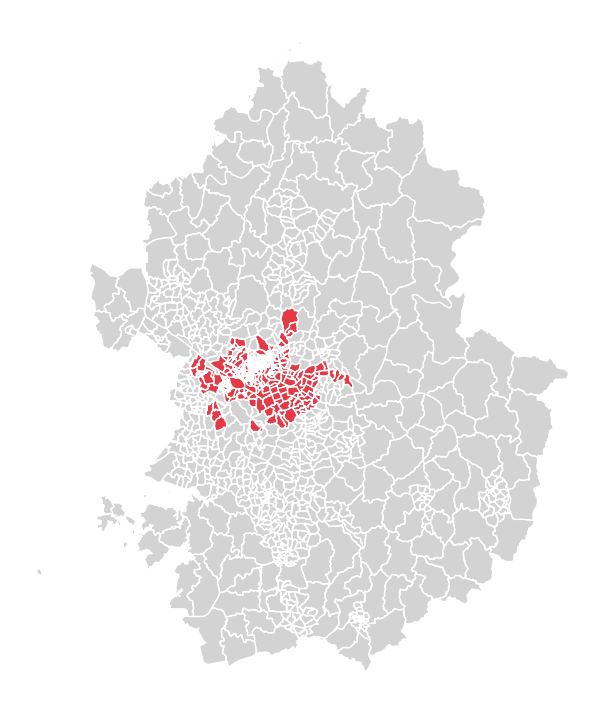

In [35]:
def making_plot(data):
    fig, ax = plt.subplots(figsize=(12, 9))
    fig.patch.set_facecolor('none')

    regions = ['서울특별시', '경기도']
    for region in regions:
        region_data = data[data['CTP_KOR_NM'] == region]
        region_data.plot(color='lightgray', edgecolor='w', label=region, ax=ax)

    cities = ['강남구', '서초구', '송파구', '강동구', '영등포구', '마포구', '성동구', '동작구', '양천구', '용산구', '중구', '광진구', '서대문구']
    for city in cities:
        city_data = data[(data['SIG_KOR_NM'] == city) & (data['CTP_KOR_NM'] == '서울특별시')]
        city_data.plot(color='#E63946', edgecolor='w', ax=ax)
        
    villages = ['방화동', '공항동', '마곡동', '등촌동', '화곡동', '상계동', '중계동', '하계동', '월계동', '정릉동', '동소문동2가', '동소문동3가',
           '제기동', '회기동', '이문동', '휘경동', '청량리동', '답십리동', '전농동', '용두동', '삼선동1가', '삼선동2가', '삼선동3가', '보문동1가', '안암동3가', 
           '동선동4가', '돈암동', '길음동', '장위동', '불광동', '대조동', '역촌동', '신사동', '증산동', '수색동', '별양동', '부림동', '원문동', '주암동', '중앙동',
           '창우동', '신장동', '덕풍동', '풍산동', '광명동', '소하동', '철산동', '하안동']
    for village in villages:
        village_data = data[(data['EMD_KOR_NM'] == village) & (data['SIG_KOR_NM'].isin(['강서구', '노원구', '동대문구', '성북구', '은평구', '과천시', '하남시', '광명시']))]
        village_data.plot(color='#E63946', edgecolor='w', ax=ax)
        
    # 성북동은 성북구와 강서구에 둘다 존재 
    # 갈현동은 은평구와 과천시에 둘다 존재
    seongbuk = data[(data['EMD_KOR_NM'] == '성북동') & (data['SIG_KOR_NM'] == '성북구')]
    seongbuk.plot(color='#E63946', edgecolor='w', ax=ax)
    galhyeon = data[(data['EMD_KOR_NM'] == '갈현동') & (data['SIG_KOR_NM'] == '은평구')]
    galhyeon.plot(color='#E63946', edgecolor='w', ax=ax)

    plt.axis('off')
    plt.show()

making_plot(smaller_df)


**2023년 1월 3일 변경 전 투기과열지구 및 조정대상지역**
* 서울특별시 전체 구
* 경기도 과천시 / 광명시 / 하남시 / 성남시(분당/수정구)
* 2023년 이전 분양받은 아파트만 적용

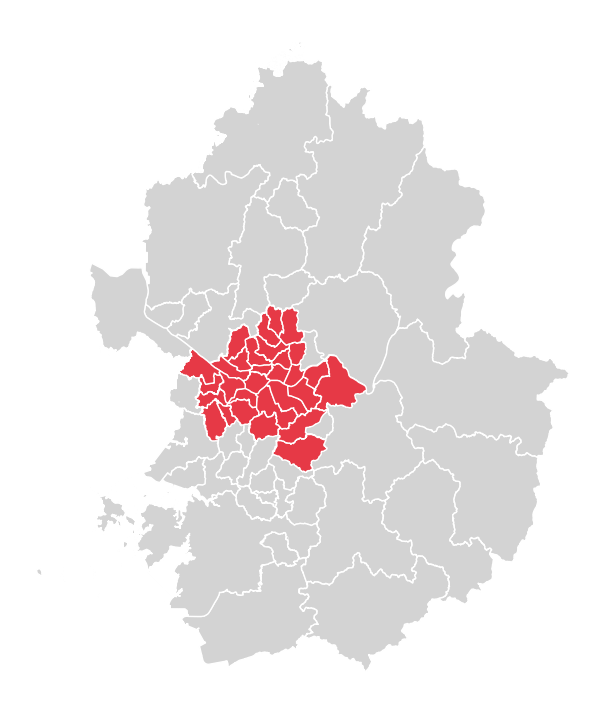

In [36]:
def making_plot(data):
    fig, ax = plt.subplots(figsize=(12, 9))
    fig.patch.set_facecolor('none')

    regions = ['서울특별시', '경기도']
    for region in regions:
        region_data = data[data['CTP_KOR_NM'] == region]
        region_data.plot(color='lightgray', edgecolor='w', label=region, ax=ax)
       
    seoul_cities = list(data[our_data['CTP_KOR_NM'] == '서울특별시']['SIG_KOR_NM'].unique())
    for city in seoul_cities:
        city_data = data[(data['SIG_KOR_NM'] == city) & (data['CTP_KOR_NM'] == '서울특별시')]
        city_data.plot(color='#E63946', edgecolor='w', ax=ax)
        
    gyeonggi_cities = ['과천시', '광명시', '하남시', '성남시 분당구', '성남시 수정구']
    for city in gyeonggi_cities:
        city_data = data[(data['SIG_KOR_NM'] == city) & (data['CTP_KOR_NM'] == '경기도')]
        city_data.plot(color='#E63946', edgecolor='w', ax=ax)

    plt.axis('off')
    plt.show()

making_plot(our_data)